In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import nbimporter

import central_system as cs
import analyze_control as ac
import read_load as rl

#import exp_study_case
#import exp_external_conditions
#import exp_system_spec
#import exp_house_spec
import exp_general_property
#import exp_occupant_usage
#import exp_circulating_air_flow
#import exp_load
#import exp_treated_and_untreated_heat


Importing Jupyter notebook from exp_general_property.ipynb
Importing Jupyter notebook from exp_study_case.ipynb


## 0. 試算に用いる値

JIS条件を用いることにする。  

冷房  
乾球温度27℃  
湿球温度19℃  

暖房  
乾球温度20℃  
湿球温度15℃  

In [2]:
p_test_h = cs.get_saturated_vapour_pressure_by_temperature(27) * 0.465675
x_test_h = 0.622 * p_test_h / (101325 - p_test_h)
(p_test_h, x_test_h)

(1662.558022566183, 0.010376136381148633)

$\rho$：空気の密度, kg/m<sup>3</sup> (=1.2)    
$c$：空気の比熱, J/kgK (=1006.0)  
$L_{wtr}$：水の蒸発潜熱, kJ/kg (=2434.5296)  

In [3]:
rho, c, l_wtr, _ = exp_general_property.get_general_property()
rho, c, l_wtr

(1.2, 1006.0, 2434.5296000000003)

### 暖房

#### 「試験時」

$\theta_{ex,rtd,H}$：定格暖房能力運転時の外気温度 (7℃)  
$\theta_{hs,in,rtd,H}$：定格暖房能力運転時の吸い込み温度 (20℃)  
$q_{hs,rtd,H}$：定格暖房能力, W  
$V_{hs,rtd,H}$：定格暖房能力運転時の風量, m<sup>3</sup>/h

In [4]:
theta_ex_rtd_h = 7.0
theta_hs_in_rtd_h = 20.0
q_hs_rtd_h = 6300  # W
v_hs_rtd_h = 1440  # m3/h

#### 「エネルギー消費量評価時」

$\theta_{ex}$：外気温度, ℃  
$\theta_{hs,in,H}$：暖房運転時の熱源機入口温度, ℃  
$\theta_{hs,out,H}$：暖房運転時の熱源機出口温度, ℃  
$V_{hs,H}$：暖房運転じの風量, m<sup>3</sup>

In [5]:
theta_ex_h = 7.0  # ℃
tehta_hs_in_h = 20.0  # ℃
theta_hs_out_h = 35.0  # ℃
v_hs_h = 1000  # m3/h

## 1. 熱交換器表面

熱交換器表面温度を計算する場合、以下の2つのケースが考えられる。
- 定格・中間試験等の全熱の処理熱量が分かっている場合
- 熱源機出口温度が分かっている場合（実際のエネルギー計算で使用）

暖房運転時は顕熱処理しかしないため、両者は式の形は違うものの同じ意味を持っている。  
一方で、冷房運転時は潜熱処理も行うため、非常に複雑である。定格・中間試験等では全熱処理量が入力条件として定められるが、顕熱処理と潜熱処理の比はわからず、熱交換器表面温度に依存する。熱交換器表面温度から決定される飽和水蒸気圧の計算等は非常に複雑で線形関係を有していないため、全熱処理量から表面温度を求めるには、一旦表面温度を決定して成り行きとして決定される全熱処理量を逆計算するといった収束計算が必要である。定格・中間試験等から表面温度を求める計算は機器の仕様に応じて１度してしまえば十分であるため、ここでは収束計算を実施する。  
一方、通常のネルギー計算の場合は熱源機出口温度が指定される。熱源機出口温度が指定されると熱交換器表面温度が概ね決定されるが、厳密には入口・出口の絶対湿度の平均値に対流熱伝達が依存するため、ここでも収束計算が発生する。ただし、その差は非常に少ないこと、通常のエネルギー計算は年間で数千回（冷房期間中）繰り返して実施しないといけないことから、簡単のため、熱伝達率の計算において、出口湿度の影響は無視することとすることで、収束計算を発生させないことにした。  
以下、試験時における熱交換器表面の計算と、通常運転時の熱交換器表面の計算については分けて議論する。両者を、「試験時」と「エネルギー消費量評価時」と表す。

### 1) 「試験時」と「エネルギー消費量評価時」で共通のパラメータ

#### 室内機熱交換器の前面面積のうち熱交換に有効な面積

$$ A_{f,hex}=0.23559 $$

$A_{f,hex}$：室内機熱交換器の前面面積のうち熱交換に有効な面積, m<sup>2</sup>

In [6]:
cs.get_a_f_hex()

0.23559

#### 室内機熱交換器の表面積のうち熱交換に有効な面積

$$ A_{e,hex} = 6.396 $$

$A_{e,hex}$：室内機熱交換器の表面積のうち熱交換に有効な面積, m<sup>2</sup>

In [7]:
cs.get_a_e_hex()

6.396

#### 暖房時の室内機熱交換器表面の顕熱伝達率

暖房時の室内機熱交換器表面の顕熱伝達率は、湿度等の出口空気の状態に対する依存性が無いため、「試験時」と「エネルギー消費量評価時」で共通である。冷房時においては、絶対湿度に関して出口空気の状態に対する依存性があるが、収束計算が発生することと、伝達率に絶対湿度依存性がそれほど大きくないため、熱交換時の絶対湿度は入口空気の状態に等しいと仮定する。これにより、冷房時においても「試験時」と「エネルギー消費量評価時」とで式は共通となる。

$$ \alpha_{c,hex,H} = \left( -0.0017 \times \left( \frac{V_{hs} \div 3600}{A_{f,hex}} \right)^{2} + 0.044 \times \left( \frac{V_{hs} \div 3600}{A_{f,hex}} \right) +0.0271 \right) \times 1000 $$

$\alpha_{c,hex,H}$：暖房時の室内機熱交換器表面の顕熱伝達率, W/m<sup>2</sup> K  
$A_{f,hex}$：室内機熱交換器の前面面積のうち熱交換に有効な面積, m<sup>2</sup>  
$V_{hs}$：熱源機の風量, m<sup>3</sup>/h  

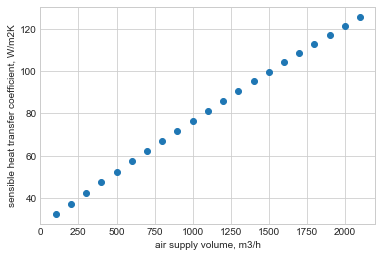

In [8]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

v_hs = np.arange(start= 100.0, stop= 2200.0, step = 100.0)
ax.scatter(v_hs, cs.get_alpha_c_hex_h(v_hs))

ax.set_xlabel('air supply volume, m3/h')
ax.set_ylabel('sensible heat transfer coefficient, W/m2K')

plt.show()

$$ \alpha'_{hex,C} = 0.050 \ln \left( \frac{ V_{hs} \div 3600 }{ A_{f,hex} } \right) + 0.073 $$

ただし、$V_{hs} < 400$ の場合は、$V_{hs}=400$ として、$\alpha'_{hex,C}$を評価する。

$$ \alpha_{c,hex,C} = \alpha'_{hex,C} \left( c + c_{pw} X_{e,in,C} \right)$$

$$ c_{pw} = 1.846 $$

$\alpha'_{hex}$：冷房時における室内機熱交換器表面の潜熱伝達率, kg/m<sup>2</sup>s  
$V_{hs}$：熱源機の風量, m<sup>3</sup>/h  
$A_{f,hex}$：室内機熱交換器の前面面積のうち熱交換に有効な面積, m<sup>2</sup>
$\alpha_{c,hex,C}$：冷房時における室内機熱交換器表面の顕熱伝達率, W/m<sup>2</sup> K  
$c$：空気の比熱, J/kgK (=1006.0)  
$c_{pw}$：水蒸気定圧比熱, J/kg K (=1846)  
$X_{e,in,C}$：冷房時の熱源機の入口空気の絶対湿度, kg/kg(DA)  

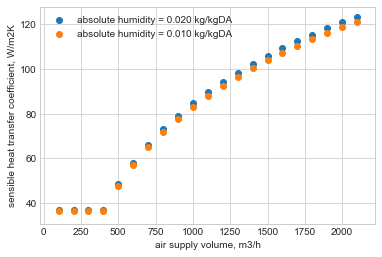

In [9]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

v_hs = np.arange(start= 100.0, stop= 2200.0, step = 100.0)
ax.scatter(v_hs, np.vectorize(cs.get_alpha_c_hex_c)(v_hs, 0.020)[0], label='absolute humidity = 0.020 kg/kgDA')
ax.scatter(v_hs, np.vectorize(cs.get_alpha_c_hex_c)(v_hs, 0.010)[0], label='absolute humidity = 0.010 kg/kgDA')

ax.set_xlabel('air supply volume, m3/h')
ax.set_ylabel('sensible heat transfer coefficient, W/m2K')

plt.legend()

plt.show()

### 2) 「試験時」における表面温度推定

#### 暖房

熱源機の入口温度・熱源機の能力・風量から室内機熱交換器の表面温度を求める。

$$ \theta_{surf,hex,test,H} = \frac{\theta_{hs,in,test,H} + \theta_{hs,out,test,H}}{2} + \frac{q_{hs,test,H} }{A_{e,hex} \alpha_{c,hex,test,H} } $$

$$ \theta_{hs,out,test,H} = \theta_{hs,in,test,H} + \frac{ q_{hs,test,H} }{ c \rho V_{hs,test,H} } \times 3600 $$

これから、  
$$ \theta_{surf,hex,test,H} = \theta_{hs,in,test,H} + \frac{ q_{hs,test,H} }{ 2 c \rho V_{hs,test,H} } \times 3600 + \frac{q_{hs,test,H} }{A_{e,hex} \alpha_{c,hex,test,H} } $$

$\theta_{surf,hex,test,H}$：暖房試験時の室内機熱交換器の表面温度, ℃  
$\theta_{hs,in,test,H}$：暖房試験時の熱源機の入口空気温度, ℃  
$\theta_{hs,out,test,H}$：暖房試験時の熱源機の出口空気温度, ℃  
$q_{hs,test,H}$：暖房試験時の熱源機の能力, W  
$A_{e,hex}$：室内機熱交換器の表面積のうち熱交換に有効な面積, m<sup>2</sup>  
$\alpha_{c,hex,test,H}$：暖房試験時における室内機熱交換器表面の顕熱伝達率, W/m<sup>2</sup> K  
$\rho$：空気の密度, kg/m<sup>3</sup> (=1.2)    
$c$：空気の比熱, J/kgK (=1006.0)  
$V_{hs,test,H}$：暖房試験時の風量, m<sup>3</sup>/h

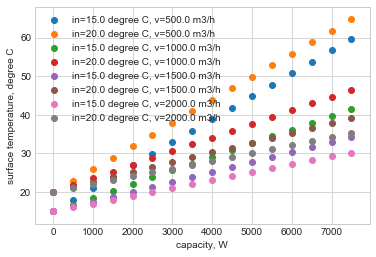

In [10]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

q_hs = np.arange(start= 0.0, stop= 8000.0, step = 500.0)
ax.scatter(q_hs, np.vectorize(cs.get_theta_surf_hex_test_h)(15.0, q_hs, 500.0), label='in=15.0 degree C, v=500.0 m3/h')
ax.scatter(q_hs, np.vectorize(cs.get_theta_surf_hex_test_h)(20.0, q_hs, 500.0), label='in=20.0 degree C, v=500.0 m3/h')
ax.scatter(q_hs, np.vectorize(cs.get_theta_surf_hex_test_h)(15.0, q_hs, 1000.0), label='in=15.0 degree C, v=1000.0 m3/h')
ax.scatter(q_hs, np.vectorize(cs.get_theta_surf_hex_test_h)(20.0, q_hs, 1000.0), label='in=20.0 degree C, v=1000.0 m3/h')
ax.scatter(q_hs, np.vectorize(cs.get_theta_surf_hex_test_h)(15.0, q_hs, 1500.0), label='in=15.0 degree C, v=1500.0 m3/h')
ax.scatter(q_hs, np.vectorize(cs.get_theta_surf_hex_test_h)(20.0, q_hs, 1500.0), label='in=20.0 degree C, v=1500.0 m3/h')
ax.scatter(q_hs, np.vectorize(cs.get_theta_surf_hex_test_h)(15.0, q_hs, 2000.0), label='in=15.0 degree C, v=2000.0 m3/h')
ax.scatter(q_hs, np.vectorize(cs.get_theta_surf_hex_test_h)(20.0, q_hs, 2000.0), label='in=20.0 degree C, v=2000.0 m3/h')

ax.set_xlabel('capacity, W')
ax.set_ylabel('surface temperature, degree C')

plt.legend()

plt.show()

#### 冷房

一旦、室内機熱交換器の表面温度を仮決めし、顕熱・潜熱能力を計算する。顕熱・潜熱能力の合計値である全熱能力が試験時の冷房能力に等しくなるように、表面温度を逆算する。

$$ \theta_{surf,hex,test,C} = \frac{\theta_{hs,in,test,C} + \theta_{hs,out,test,C}}{2} - \frac{q_{hs,test,CS} }{A_{e,hex} \alpha_{c,hex,C}} $$

$$ \theta_{hs,out,test,C} = \theta_{hs,in,test,C} - \frac{ q_{hs,test,CS} }{ c \rho V_{hs,test,C} } \times 3600 $$


$$ q_{hs,test,CS} = \left( \theta_{hs,in,test,C} - \theta_{surf,hex,test,C} \right) \div \left( \frac{3600}{ 2 c \rho V_{hs,test,C} } + \frac{1}{A_{e,hex} \alpha_{c,hex,test,C} } \right) $$

$\theta_{surf,hex,test,C}$：冷房試験時の室内機熱交換器の表面温度, ℃  
$\theta_{hs,in,test,C}$：冷房試験時の熱源機の入口空気温度, ℃  
$\theta_{hs,out,test,C}$：冷房試験時の熱源機の出口空気温度, ℃  
$q_{hs,test,CS}$：冷房試験時の顕熱能力, W  
$\alpha_{c,hex,C}$：冷房試験時の室内機熱交換器表面の顕熱伝達率, W/m<sup>2</sup> K  
$A_{e,hex}$：室内機熱交換器の表面積のうち熱交換に有効な面積, m<sup>2</sup>  
$V_{hs,test,C}$：冷房試験時の風量, m<sup>3</sup>/h  
$\rho$：空気の密度, kg/m<sup>3</sup> (=1.2)    
$c$：空気の比熱, J/kgK (=1006.0)



$$ X_{surf,hex,test,C} = \frac{X_{hs,in,test,C} + X_{hs,out,test,C}}{2} - \frac{q_{hs,test,CL} }{L_{wtr} A_{e,hex} \alpha'_{hex,C} \times 10^3} $$

$$ X_{hs,out,test,C} = X_{hs,in,test,C} - \frac{ q_{hs,test,CL} }{ L_{wtr} \rho V_{hs,test,C} \times 10^{3} } \times 3600 $$

これらから、

$$ q_{hs,test,CL} = \left( X_{hs,in,test,C} - X_{surf,hex,test,C} \right) \div \left( \frac{3600}{ 2 L_{wtr} \rho V_{hs,test,C} \times 10^{3} } + \frac{1}{L_{wtr} A_{e,hex} \alpha'_{hex,test,C} \times 10^3 } \right) $$

ただし、$q_{hs,test,CL} \lt 0$ の場合は、$q_{hs,test,CL} = 0$ とする。

$X_{surf,hex,test,C}$：冷房試験時の室内機熱交換器の表面絶対湿度, kg/kgDA  
$X_{hs,in,test,C}$：冷房試験時の熱源機の入口空気絶対湿度, kg/kgDA  
$X_{hs,out,test,C}$：冷房試験時の熱源機の出口空気絶対湿度, kg/kgDA  
$q_{hs,test,CL}$：冷房試験時の潜熱能力, W  
$\alpha'_{hex,C}$：冷房試験時の室内機熱交換器表面の潜熱伝達率, kg/m<sup>2</sup> s  
$A_{e,hex}$：室内機熱交換器の表面積のうち熱交換に有効な面積, m<sup>2</sup>  
$V_{hs,test,C}$：冷房試験時の風量, m<sup>3</sup>/h  
$\rho$：空気の密度, kg/m<sup>3</sup> (=1.2)    
$c$：空気の比熱, J/kgK (=1006.0)  
$L_{wtr}$：水の蒸発潜熱, kJ/kg  

ここで、$X_{surf,hex,test,C}$ は、$\theta_{surf,hex,test,C}$ の場合の飽和時の絶対湿度とする。

$$q_{hs,test,C} = q_{hs,test,CS} + q_{hs,test,CL}$$

$q_{hs,test,C}$：冷房試験時の能力, W  
$q_{hs,test,CS}$：冷房試験時の顕熱能力, W  
$q_{hs,test,CL}$：冷房試験時の潜熱能力, W  

冷房試験時の能力$q_{hs,test,C}$を満たす冷房試験時の室内機熱交換器の表面温度$\theta_{surf,hex,test,C}$を収束計算等により計算する。

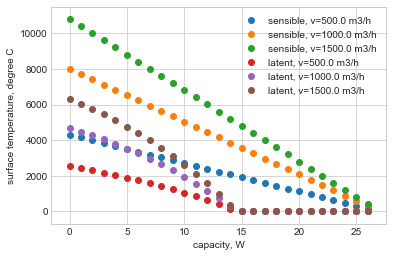

In [11]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

# 27 ℃のときの飽和絶対湿度は、0.0227 kg/kgDA

theta_surf_hex_c = np.arange(start= 0.0, stop= 27.0, step = 1.0)
ax.scatter(theta_surf_hex_c, np.vectorize(cs.get_q_hs_test_c)(27.0, 0.010376, theta_surf_hex_c, 500.0)[1], label='sensible, v=500.0 m3/h')
ax.scatter(theta_surf_hex_c, np.vectorize(cs.get_q_hs_test_c)(27.0, 0.010376, theta_surf_hex_c, 1000.0)[1], label='sensible, v=1000.0 m3/h')
ax.scatter(theta_surf_hex_c, np.vectorize(cs.get_q_hs_test_c)(27.0, 0.010376, theta_surf_hex_c, 1500.0)[1], label='sensible, v=1500.0 m3/h')
ax.scatter(theta_surf_hex_c, np.vectorize(cs.get_q_hs_test_c)(27.0, 0.010376, theta_surf_hex_c, 500.0)[2], label='latent, v=500.0 m3/h')
ax.scatter(theta_surf_hex_c, np.vectorize(cs.get_q_hs_test_c)(27.0, 0.010376, theta_surf_hex_c, 1000.0)[2], label='latent, v=1000.0 m3/h')
ax.scatter(theta_surf_hex_c, np.vectorize(cs.get_q_hs_test_c)(27.0, 0.010376, theta_surf_hex_c, 1500.0)[2], label='latent, v=1500.0 m3/h')

ax.set_xlabel('capacity, W')
ax.set_ylabel('surface temperature, degree C')

plt.legend()

plt.show()

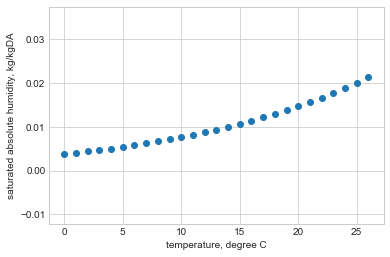

In [12]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

theta_surf_hex_c = np.arange(start= 0.0, stop= 27.0, step = 1.0)
ax.scatter(theta_surf_hex_c, np.vectorize(cs.get_saturated_absolute_humidity)(theta_surf_hex_c))

ax.set_xlabel('temperature, degree C')
ax.set_ylabel('saturated absolute humidity, kg/kgDA')

plt.show()


In [13]:
def get_f(v_hs, q):
    return lambda theta_surf_hex_c: cs.get_q_hs_test_c(27.0, 0.010376, theta_surf_hex_c, v_hs)[0] - q

f = get_f(1000.0, 5000.0)
optimize.fsolve(f,0)

array([12.85419588])

C:\Users\miura\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


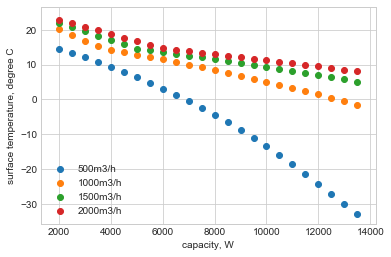

In [14]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

q_hs_c = np.arange(start= 2000, stop= 14000, step = 500)
ax.scatter(q_hs_c, np.vectorize(cs.get_theta_surf_hex_test_c)(theta_hs_in_c=27.0, x_hs_in_c=0.010376, v_hs=500.0, q_hs_c=q_hs_c), label='500m3/h')
ax.scatter(q_hs_c, np.vectorize(cs.get_theta_surf_hex_test_c)(theta_hs_in_c=27.0, x_hs_in_c=0.010376, v_hs=1000.0, q_hs_c=q_hs_c), label='1000m3/h')
ax.scatter(q_hs_c, np.vectorize(cs.get_theta_surf_hex_test_c)(theta_hs_in_c=27.0, x_hs_in_c=0.010376, v_hs=1500.0, q_hs_c=q_hs_c), label='1500m3/h')
ax.scatter(q_hs_c, np.vectorize(cs.get_theta_surf_hex_test_c)(theta_hs_in_c=27.0, x_hs_in_c=0.010376, v_hs=2000.0, q_hs_c=q_hs_c), label='2000m3/h')

ax.set_xlabel('capacity, W')
ax.set_ylabel('surface temperature, degree C')

plt.legend()

plt.show()

### 3) 「エネルギー消費量評価時」における表面温度推定

熱源機の入口温度・出口温度・風量から室内機熱交換器の表面温度を求める。

$$ \theta_{surf,hex,H} = \frac{\theta_{hs,in,H} + \theta_{hs,out,H}}{2} + \frac{q_{hs,H} }{A_{e,hex} \alpha_{c,hex,H} } $$

$$ \theta_{hs,out,H} = \theta_{hs,in,H} + \frac{ q_{hs,H} }{ c \rho V_{hs,H} } \times 3600 $$

これから、  
$$ \theta_{surf,hex,H} = \frac{\theta_{hs,in,H} + \theta_{hs,out,H}}{2} + \frac{ ( \theta_{hs,out,H} - \theta_{hs,in,H} ) c \rho V_{hs,H} \times 3600^{-1} }{A_{e,hex} \alpha_{c,hex,H} } $$


$\theta_{surf,hex,H}$：暖房時の室内機熱交換器の表面温度, ℃  
$\theta_{hs,in,H}$：暖房時の熱源機の入口空気温度, ℃  
$\theta_{hs,out,H}$：暖房時の熱源機の出口空気温度, ℃  
$q_{hs,H}$：暖房時の熱源機の能力, W  
$A_{e,hex}$：室内機熱交換器の表面積のうち熱交換に有効な面積, m<sup>2</sup>  
$\alpha_{c,hex,H}$：暖房時における室内機熱交換器表面の顕熱伝達率, W/m<sup>2</sup> K  
$\rho$：空気の密度, kg/m<sup>3</sup> (=1.2)    
$c$：空気の比熱, J/kgK (=1006.0)  
$V_{hs,H}$：暖房時の熱源機の風量, m<sup>3</sup>/h

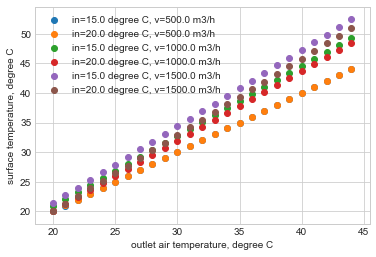

In [15]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

theta_hs_out_h = np.arange(start= 20.0, stop= 45.0, step = 1.0)
ax.scatter(theta_hs_out_h, np.vectorize(cs.get_theta_surf_hex_h)(15.0, theta_hs_out_h, 500.0), label='in=15.0 degree C, v=500.0 m3/h')
ax.scatter(theta_hs_out_h, np.vectorize(cs.get_theta_surf_hex_h)(20.0, theta_hs_out_h, 500.0), label='in=20.0 degree C, v=500.0 m3/h')
ax.scatter(theta_hs_out_h, np.vectorize(cs.get_theta_surf_hex_h)(15.0, theta_hs_out_h, 1000.0), label='in=15.0 degree C, v=1000.0 m3/h')
ax.scatter(theta_hs_out_h, np.vectorize(cs.get_theta_surf_hex_h)(20.0, theta_hs_out_h, 1000.0), label='in=20.0 degree C, v=1000.0 m3/h')
ax.scatter(theta_hs_out_h, np.vectorize(cs.get_theta_surf_hex_h)(15.0, theta_hs_out_h, 1500.0), label='in=15.0 degree C, v=1500.0 m3/h')
ax.scatter(theta_hs_out_h, np.vectorize(cs.get_theta_surf_hex_h)(20.0, theta_hs_out_h, 1500.0), label='in=20.0 degree C, v=1500.0 m3/h')

ax.set_xlabel('outlet air temperature, degree C')
ax.set_ylabel('surface temperature, degree C')

plt.legend()

plt.show()

$$ \theta_{surf,hex,C} = \frac{\theta_{hs,in,C} + \theta_{hs,out,C}}{2} - \frac{q_{hs,CS} }{A_{e,hex} \alpha_{c,hex,C}} $$

$$ \theta_{hs,out,C} = \theta_{hs,in,C} - \frac{ q_{hs,CS} }{ c \rho V_{hs,C} } \times 3600 $$

これから、

$$ \theta_{surf,hex,C} = \frac{\theta_{hs,in,C} + \theta_{hs,out,C}}{2} - \frac{ ( \theta_{hs,in,C} - \theta_{hs,out,C} ) c \rho V_{hs,C} \times 3600^{-1} }{A_{e,hex} \alpha_{c,hex,C} } $$

$\theta_{surf,hex,C}$：冷房時の室内機熱交換器の表面温度, ℃  
$\theta_{hs,in,C}$：冷房時の熱源機の入口空気温度, ℃  
$\theta_{hs,out,C}$：冷房時の熱源機の出口空気温度, ℃  
$q_{hs,CS}$：冷房顕熱能力, W  
$\alpha_{c,hex,C}$：冷房時の室内機熱交換器表面の顕熱伝達率, W/m<sup>2</sup> K  
$A_{e,hex}$：室内機熱交換器の表面積のうち熱交換に有効な面積, m<sup>2</sup>  
$V_{hs,C}$：冷房時の風量, m<sup>3</sup>/h  
$\rho$：空気の密度, kg/m<sup>3</sup> (=1.2)    
$c$：空気の比熱, J/kgK (=1006.0)

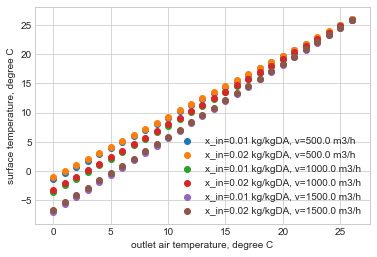

In [16]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

theta_hs_out_c = np.arange(start= 0.0, stop= 27.0, step = 1.0)
ax.scatter(theta_hs_out_c, np.vectorize(cs.get_theta_surf_hex_c)(27.0, 0.01, theta_hs_out_c, 500.0), label='x_in=0.01 kg/kgDA, v=500.0 m3/h')
ax.scatter(theta_hs_out_c, np.vectorize(cs.get_theta_surf_hex_c)(27.0, 0.02, theta_hs_out_c, 500.0), label='x_in=0.02 kg/kgDA, v=500.0 m3/h')
ax.scatter(theta_hs_out_c, np.vectorize(cs.get_theta_surf_hex_c)(27.0, 0.01, theta_hs_out_c, 1000.0), label='x_in=0.01 kg/kgDA, v=1000.0 m3/h')
ax.scatter(theta_hs_out_c, np.vectorize(cs.get_theta_surf_hex_c)(27.0, 0.02, theta_hs_out_c, 1000.0), label='x_in=0.02 kg/kgDA, v=1000.0 m3/h')
ax.scatter(theta_hs_out_c, np.vectorize(cs.get_theta_surf_hex_c)(27.0, 0.01, theta_hs_out_c, 1500.0), label='x_in=0.01 kg/kgDA, v=1500.0 m3/h')
ax.scatter(theta_hs_out_c, np.vectorize(cs.get_theta_surf_hex_c)(27.0, 0.02, theta_hs_out_c, 1500.0), label='x_in=0.02 kg/kgDA, v=1500.0 m3/h')

ax.set_xlabel('outlet air temperature, degree C')
ax.set_ylabel('surface temperature, degree C')

plt.legend()

plt.show()

## 2. 冷媒温度

### 暖房

$$ \theta_{ref,cnd,H} = \theta_{surf,hex,H} $$

ただし、$\theta_{ref,cnd,H} \gt 65$ の場合、$\theta_{ref,cnd,H} = 65$ とする。

$$ \theta_{ref,evp,H} = \theta_{ex} - \left( 0.100 \theta_{ref,cnd,H} + 2.95 \right) $$

ただし、$\theta_{ref,evp,H} \lt -50$ の場合、$\theta_{ref,evp,H} = -50$ とする。

$$ \theta_{ref,SC,H} = 0.245 \theta_{ref,cnd,H} - 1.72 $$

$$ \theta_{ref,SH,H} = 4.49 - 0.036 \theta_{ref,cnd,H} $$

$\theta_{ref,evp,H}$：暖房時の蒸発温度, ℃  
$\theta_{ref,cnd,H}$：暖房時の凝縮温度, ℃  
$\theta_{ref,SC,H}$：暖房時の過冷却度, ℃  
$\theta_{ref,SH,H}$：暖房時の過熱度, ℃  
$\theta_{ex}$：外気温度, ℃  
$\theta_{surf,hex,H}$：暖房時の室内機熱交換器の表面温度, ℃

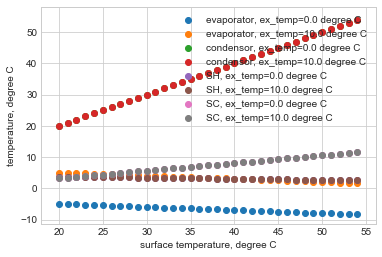

In [17]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

theta_surf_hex_h = np.arange(start= 20.0, stop= 55.0, step = 1.0)
ax.scatter(theta_surf_hex_h, np.vectorize(cs.get_refrigerant_temperature_heating)(0.0, theta_surf_hex_h)[0], label='evaporator, ex_temp=0.0 degree C')
ax.scatter(theta_surf_hex_h, np.vectorize(cs.get_refrigerant_temperature_heating)(10.0, theta_surf_hex_h)[0], label='evaporator, ex_temp=10.0 degree C')
ax.scatter(theta_surf_hex_h, np.vectorize(cs.get_refrigerant_temperature_heating)(0.0, theta_surf_hex_h)[1], label='condensor, ex_temp=0.0 degree C')
ax.scatter(theta_surf_hex_h, np.vectorize(cs.get_refrigerant_temperature_heating)(10.0, theta_surf_hex_h)[1], label='condensor, ex_temp=10.0 degree C')
ax.scatter(theta_surf_hex_h, np.vectorize(cs.get_refrigerant_temperature_heating)(0.0, theta_surf_hex_h)[2], label='SH, ex_temp=0.0 degree C')
ax.scatter(theta_surf_hex_h, np.vectorize(cs.get_refrigerant_temperature_heating)(10.0, theta_surf_hex_h)[2], label='SH, ex_temp=10.0 degree C')
ax.scatter(theta_surf_hex_h, np.vectorize(cs.get_refrigerant_temperature_heating)(0.0, theta_surf_hex_h)[3], label='SC, ex_temp=0.0 degree C')
ax.scatter(theta_surf_hex_h, np.vectorize(cs.get_refrigerant_temperature_heating)(10.0, theta_surf_hex_h)[3], label='SC, ex_temp=10.0 degree C')

ax.set_xlabel('surface temperature, degree C')
ax.set_ylabel('temperature, degree C')

plt.legend()

plt.show()

### 冷房

$$ \theta_{ref,evp,C} = \theta_{surf,hex,C} $$

ただし、$\theta_{ref,evp,C} \lt -50$ の場合、$\theta_{ref,evp,C} = -50$ とする。

$$ \theta_{ref,cnd,C} = \theta_{ex} + 27.4 - 1.35 \theta_{ref,evp,C} $$

ただし、$\theta_{ref,cnd,C} \lt \theta_{ex}$ の場合、$\theta_{ref,cnd,C} = \theta_{ex}$ とする。また、その結果、$\theta_{ref,cnd,C} \gt 65$ の場合、$\theta_{ref,cnd,C} = 65$ とする。

$$ \theta_{ref,SC,C} = 0.772 \theta_{ref,cnd,C} - 25.6 $$
$$ \theta_{ref,SH,C} = 0.194 \theta_{ref,cnd,C} - 3.86 $$

$\theta_{ref,evp,C}$：冷房時の蒸発温度, ℃  
$\theta_{ref,cnd,C}$：冷房時の凝縮温度, ℃  
$\theta_{ref,SC,C}$：冷房時の過冷却度, ℃  
$\theta_{ref,SH,C}$：冷房時の過熱度, ℃  
$\theta_{ex}$：外気温度, ℃  
$\theta_{surf,hex,C}$：冷房時の室内機熱交換器の表面温度, ℃  


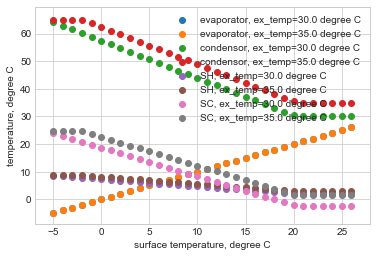

In [18]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

theta_surf_hex_c = np.arange(start= -5.0, stop= 27.0, step = 1.0)
ax.scatter(theta_surf_hex_c, np.vectorize(cs.get_refrigerant_temperature_cooling)(30.0, theta_surf_hex_c)[0], label='evaporator, ex_temp=30.0 degree C')
ax.scatter(theta_surf_hex_c, np.vectorize(cs.get_refrigerant_temperature_cooling)(35.0, theta_surf_hex_c)[0], label='evaporator, ex_temp=35.0 degree C')
ax.scatter(theta_surf_hex_c, np.vectorize(cs.get_refrigerant_temperature_cooling)(30.0, theta_surf_hex_c)[1], label='condensor, ex_temp=30.0 degree C')
ax.scatter(theta_surf_hex_c, np.vectorize(cs.get_refrigerant_temperature_cooling)(35.0, theta_surf_hex_c)[1], label='condensor, ex_temp=35.0 degree C')
ax.scatter(theta_surf_hex_c, np.vectorize(cs.get_refrigerant_temperature_cooling)(30.0, theta_surf_hex_c)[2], label='SH, ex_temp=30.0 degree C')
ax.scatter(theta_surf_hex_c, np.vectorize(cs.get_refrigerant_temperature_cooling)(35.0, theta_surf_hex_c)[2], label='SH, ex_temp=35.0 degree C')
ax.scatter(theta_surf_hex_c, np.vectorize(cs.get_refrigerant_temperature_cooling)(30.0, theta_surf_hex_c)[3], label='SC, ex_temp=30.0 degree C')
ax.scatter(theta_surf_hex_c, np.vectorize(cs.get_refrigerant_temperature_cooling)(35.0, theta_surf_hex_c)[3], label='SC, ex_temp=35.0 degree C')

ax.set_xlabel('surface temperature, degree C')
ax.set_ylabel('temperature, degree C')

plt.legend()

plt.show()

## 3. ヒートポンプの理論効率

蒸発温度$\theta_{ref,evp}$、凝縮温度$T_{ref,cnd}$、過冷却度$T_{SC}$及び過熱度$T_{SH}$ から理論効率$e_{th,H}$を求める。

計算式の説明は省略する。詳細は、4章8節「ルームエアコンディショナー付床暖房」付録Aを参照のこと。

4章8節「ルームエアコンディショナー付床暖房」付録Aは暖房時における理論効率であるので、冷房時の理論効率は1をひかないといけない。つまり、

$$ e_{th,C} = e_{th,H} - 1 $$

$e_{th,H}$：冷凍サイクルの理論暖房効率  
$e_{th,C}$：冷凍サイクルの理論冷房効率

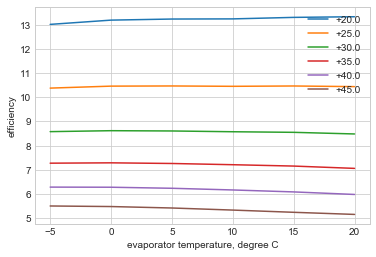

In [19]:
evps = [-5.0, 0.0, 5.0, 10.0, 15.0, 20.0]

plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

ax.plot(evps, [cs.get_heat_pump_theoretical_efficiency_heating(evp, evp + 20.0, 2.0, 2.0) for evp in evps], label='+20.0')
ax.plot(evps, [cs.get_heat_pump_theoretical_efficiency_heating(evp, evp + 25.0, 2.0, 2.0) for evp in evps], label='+25.0')
ax.plot(evps, [cs.get_heat_pump_theoretical_efficiency_heating(evp, evp + 30.0, 2.0, 2.0) for evp in evps], label='+30.0')
ax.plot(evps, [cs.get_heat_pump_theoretical_efficiency_heating(evp, evp + 35.0, 2.0, 2.0) for evp in evps], label='+35.0')
ax.plot(evps, [cs.get_heat_pump_theoretical_efficiency_heating(evp, evp + 40.0, 2.0, 2.0) for evp in evps], label='+40.0')
ax.plot(evps, [cs.get_heat_pump_theoretical_efficiency_heating(evp, evp + 45.0, 2.0, 2.0) for evp in evps], label='+45.0')

ax.set_xlabel('evaporator temperature, degree C')
ax.set_ylabel('efficiency')

plt.legend()
plt.show()

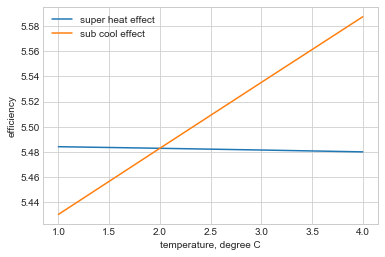

In [20]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

shs = [1.0, 2.0, 3.0, 4.0]
scs = [1.0, 2.0, 3.0, 4.0]

ax.plot(shs, [cs.get_heat_pump_theoretical_efficiency_heating(0.0, 45.0, sh, 2.0) for sh in shs], label='super heat effect')
ax.plot(scs, [cs.get_heat_pump_theoretical_efficiency_heating(0.0, 45.0, 2.0, sc) for sc in scs], label='sub cool effect')

ax.set_xlabel('temperature, degree C')
ax.set_ylabel('efficiency')

plt.legend()
plt.show()

## 4. 外部モジュールへの引き渡し

本モジュールを外部のモジュールから呼び出して必要な値を取得する場合に利用する関数を定義します。

### 暖房試験時

In [21]:
def get_e_th_h_test(theta_hs_in_h: float, q_hs_h: float, v_hs: float, theta_ex: float) -> float:
    """
    Args:
        theta_hs_in_h: inlet air temperature, degree C
        q_hs_h: sensible heating capacity, W
        v_hs: supply air volume, m3/h
        theta_ex: external temperature, degree C
    Returns:
        theoretical heat pump efficiency
    """
    
    # surface temperature, degree C
    theta_surf_hex_test_h = cs.get_theta_surf_hex_test_h(theta_hs_in_h, q_hs_h, v_hs)
    
    # evaporater temperature, condensor temperature, super heat temperature, suc cool temperature, degree C
    theta_ref_evp_h, theta_ref_cnd_h, theta_ref_sh_h, theta_ref_sc_h = cs.get_refrigerant_temperature_heating(theta_ex, theta_surf_hex_test_h)
    
    e_th_h_test = cs.get_heat_pump_theoretical_efficiency_heating(theta_ref_evp_h, theta_ref_cnd_h, theta_ref_sh_h, theta_ref_sc_h)
    
    return e_th_h_test

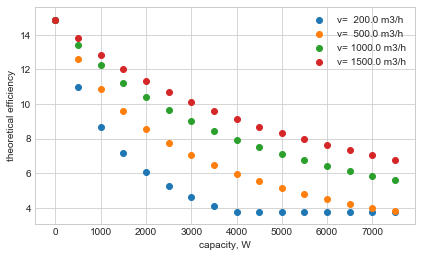

In [22]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121)

q_hs_h = np.arange(start= 0.0, stop= 8000.0, step = 500.0)
ax1.scatter(q_hs_h, np.vectorize(get_e_th_h_test)(20.0, q_hs_h,  200.0, 7.0), label='v=  200.0 m3/h')
ax1.scatter(q_hs_h, np.vectorize(get_e_th_h_test)(20.0, q_hs_h,  500.0, 7.0), label='v=  500.0 m3/h')
ax1.scatter(q_hs_h, np.vectorize(get_e_th_h_test)(20.0, q_hs_h, 1000.0, 7.0), label='v= 1000.0 m3/h')
ax1.scatter(q_hs_h, np.vectorize(get_e_th_h_test)(20.0, q_hs_h, 1500.0, 7.0), label='v= 1500.0 m3/h')

ax1.set_xlabel('capacity, W')
ax1.set_ylabel('theoretical efficiency')

ax1.legend()

plt.show()

### 冷房試験時

In [23]:
def get_e_th_c_test(theta_hs_in_c: float, x_hs_in_c: float, q_hs_c: float, v_hs: float, theta_ex: float) -> float:
    """
    Args:
        theta_hs_in_c: inlet air temperature, degree C
        x_hs_in_c: inlet air absolute humidity, kg/kgDA
        q_hs_c: sensible and latent cooling capacity, W
        v_hs: supply air volume, m3/h
        theta_ex: external temperature, degree C
    Returns:
        theoretical heat pump efficiency
    """
    
    # surface temperature, degree C
    theta_surf_hex_test_c = cs.get_theta_surf_hex_test_c(theta_hs_in_c, x_hs_in_c, v_hs, q_hs_c)
    
    # evaporater temperature, condensor temperature, super heat temperature, suc cool temperature, degree C
    theta_ref_evp_c, theta_ref_cnd_c, theta_ref_sh_c, theta_ref_sc_c = cs.get_refrigerant_temperature_cooling(theta_ex, theta_surf_hex_test_c)

    # theoretical efficiency
    e_th_c_test = cs.get_heat_pump_theoretical_efficiency_cooling(theta_ref_evp_c, theta_ref_cnd_c, theta_ref_sh_c, theta_ref_sc_c)
    
    return e_th_c_test

C:\Users\miura\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


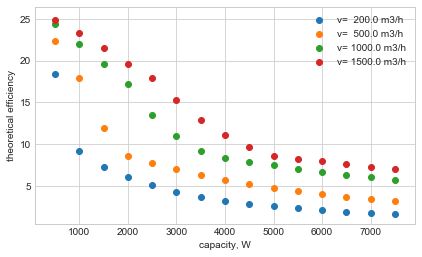

In [24]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(121)

q_hs_c = np.arange(start= 500.0, stop= 8000.0, step = 500.0)
ax.scatter(q_hs_c, np.vectorize(get_e_th_c_test)(27.0, 0.010376, q_hs_c,  200.0, 35.0), label='v=  200.0 m3/h')
ax.scatter(q_hs_c, np.vectorize(get_e_th_c_test)(27.0, 0.010376, q_hs_c,  500.0, 35.0), label='v=  500.0 m3/h')
ax.scatter(q_hs_c, np.vectorize(get_e_th_c_test)(27.0, 0.010376, q_hs_c, 1000.0, 35.0), label='v= 1000.0 m3/h')
ax.scatter(q_hs_c, np.vectorize(get_e_th_c_test)(27.0, 0.010376, q_hs_c, 1500.0, 35.0), label='v= 1500.0 m3/h')

ax.set_xlabel('capacity, W')
ax.set_ylabel('theoretical efficiency')

ax.legend()

plt.show()

### 暖房エネルギー消費量評価時

In [25]:
def get_e_th_h(theta_hs_in_h: float, theta_hs_out_h: float, v_hs: float, theta_ex: float) -> float:
    """
    Args:
        theta_hs_in_h: inlet air temperature, degree C
        theta_hs_out_h: outlet air temperature, degree C
        v_hs: supply air volume, m3/h
        theta_ex: external temperature, degree C
    Returns:
        theoretical heat pump efficiency
    """
    
    # surface temperature, degree C
    theta_surf_hex_h = cs.get_theta_surf_hex_h(theta_hs_in_h, theta_hs_out_h, v_hs)
    
    # evaporater temperature, condensor temperature, super heat temperature, suc cool temperature, degree C
    theta_ref_evp_h, theta_ref_cnd_h, theta_ref_sh_h, theta_ref_sc_h = cs.get_refrigerant_temperature_heating(theta_ex, theta_surf_hex_h)
    
    return cs.get_heat_pump_theoretical_efficiency_heating(theta_ref_evp_h, theta_ref_cnd_h, theta_ref_sh_h, theta_ref_sc_h)

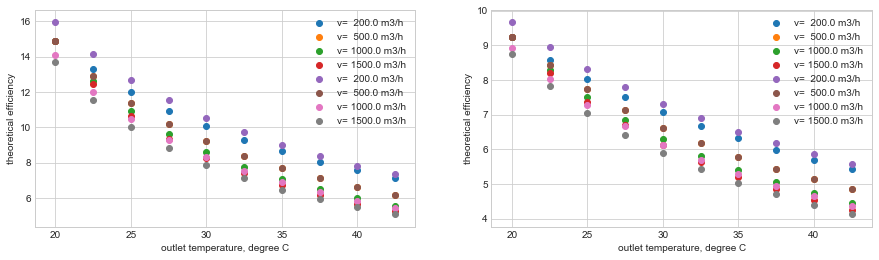

In [26]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,4))

theta_hs_out_h = np.arange(start= 20.0, stop= 45.0, step = 2.5)

ax1 = fig.add_subplot(121)
ax1.scatter(theta_hs_out_h, np.vectorize(get_e_th_h)(20.0, theta_hs_out_h,  200.0, 7.0), label='v=  200.0 m3/h')
ax1.scatter(theta_hs_out_h, np.vectorize(get_e_th_h)(20.0, theta_hs_out_h,  500.0, 7.0), label='v=  500.0 m3/h')
ax1.scatter(theta_hs_out_h, np.vectorize(get_e_th_h)(20.0, theta_hs_out_h, 1000.0, 7.0), label='v= 1000.0 m3/h')
ax1.scatter(theta_hs_out_h, np.vectorize(get_e_th_h)(20.0, theta_hs_out_h, 1500.0, 7.0), label='v= 1500.0 m3/h')
ax1.scatter(theta_hs_out_h, np.vectorize(get_e_th_h)(15.0, theta_hs_out_h,  200.0, 7.0), label='v=  200.0 m3/h')
ax1.scatter(theta_hs_out_h, np.vectorize(get_e_th_h)(15.0, theta_hs_out_h,  500.0, 7.0), label='v=  500.0 m3/h')
ax1.scatter(theta_hs_out_h, np.vectorize(get_e_th_h)(15.0, theta_hs_out_h, 1000.0, 7.0), label='v= 1000.0 m3/h')
ax1.scatter(theta_hs_out_h, np.vectorize(get_e_th_h)(15.0, theta_hs_out_h, 1500.0, 7.0), label='v= 1500.0 m3/h')

ax1.set_xlabel('outlet temperature, degree C')
ax1.set_ylabel('theoretical efficiency')

ax1.legend()

ax2 = fig.add_subplot(122)
ax2.scatter(theta_hs_out_h, np.vectorize(get_e_th_h)(20.0, theta_hs_out_h,  200.0, -3.0), label='v=  200.0 m3/h')
ax2.scatter(theta_hs_out_h, np.vectorize(get_e_th_h)(20.0, theta_hs_out_h,  500.0, -3.0), label='v=  500.0 m3/h')
ax2.scatter(theta_hs_out_h, np.vectorize(get_e_th_h)(20.0, theta_hs_out_h, 1000.0, -3.0), label='v= 1000.0 m3/h')
ax2.scatter(theta_hs_out_h, np.vectorize(get_e_th_h)(20.0, theta_hs_out_h, 1500.0, -3.0), label='v= 1500.0 m3/h')
ax2.scatter(theta_hs_out_h, np.vectorize(get_e_th_h)(15.0, theta_hs_out_h,  200.0, -3.0), label='v=  200.0 m3/h')
ax2.scatter(theta_hs_out_h, np.vectorize(get_e_th_h)(15.0, theta_hs_out_h,  500.0, -3.0), label='v=  500.0 m3/h')
ax2.scatter(theta_hs_out_h, np.vectorize(get_e_th_h)(15.0, theta_hs_out_h, 1000.0, -3.0), label='v= 1000.0 m3/h')
ax2.scatter(theta_hs_out_h, np.vectorize(get_e_th_h)(15.0, theta_hs_out_h, 1500.0, -3.0), label='v= 1500.0 m3/h')

ax2.set_xlabel('outlet temperature, degree C')
ax2.set_ylabel('theoretical efficiency')

ax2.legend()

plt.show()

### 冷房エネルギー消費量評価時

In [27]:
def get_e_th_c(theta_hs_in_c: float, x_hs_in_c: float, theta_hs_out_c: float, v_hs: float, theta_ex: float) -> float:
    """
    Args:
        theta_hs_in_c: inlet air temperature, degree C
        x_hs_in_c: inlet air absolute humidity, kg/kgDA
        theta_hs_out_c: outlet air temperature, degree C
        v_hs: supply air volume, m3/h
        theta_ex: external temperature, degree C
    Returns:
        theoretical heat pump efficiency
    """
    
    # surface temperature, degree C
    theta_surf_hex_c = cs.get_theta_surf_hex_c(theta_hs_in_c, x_hs_in_c, theta_hs_out_c, v_hs)
    
    # evaporater temperature, condensor temperature, super heat temperature, suc cool temperature, degree C
    theta_ref_evp_c, theta_ref_cnd_c, theta_ref_sh_c, theta_ref_sc_c = cs.get_refrigerant_temperature_cooling(theta_ex, theta_surf_hex_c)

    return cs.get_heat_pump_theoretical_efficiency_cooling(theta_ref_evp_c, theta_ref_cnd_c, theta_ref_sh_c, theta_ref_sc_c)

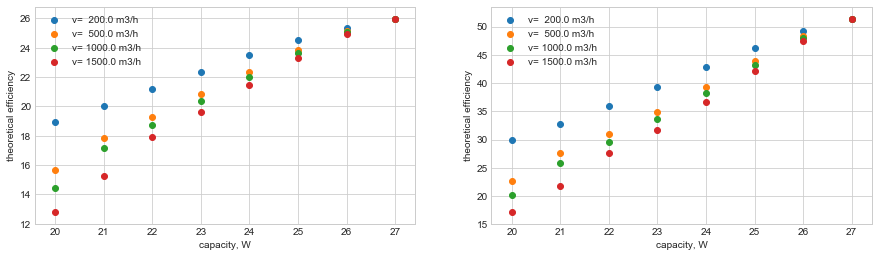

In [28]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,4))

theta_hs_out_c = np.arange(start= 20.0, stop= 28.0, step =1.0)

ax1 = fig.add_subplot(121)
ax1.scatter(theta_hs_out_c, np.vectorize(get_e_th_c)(27.0, 0.010376, theta_hs_out_c,  200.0, 35.0), label='v=  200.0 m3/h')
ax1.scatter(theta_hs_out_c, np.vectorize(get_e_th_c)(27.0, 0.010376, theta_hs_out_c,  500.0, 35.0), label='v=  500.0 m3/h')
ax1.scatter(theta_hs_out_c, np.vectorize(get_e_th_c)(27.0, 0.010376, theta_hs_out_c, 1000.0, 35.0), label='v= 1000.0 m3/h')
ax1.scatter(theta_hs_out_c, np.vectorize(get_e_th_c)(27.0, 0.010376, theta_hs_out_c, 1500.0, 35.0), label='v= 1500.0 m3/h')
ax1.set_xlabel('capacity, W')
ax1.set_ylabel('theoretical efficiency')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.scatter(theta_hs_out_c, np.vectorize(get_e_th_c)(27.0, 0.010376, theta_hs_out_c,  200.0, 30.0), label='v=  200.0 m3/h')
ax2.scatter(theta_hs_out_c, np.vectorize(get_e_th_c)(27.0, 0.010376, theta_hs_out_c,  500.0, 30.0), label='v=  500.0 m3/h')
ax2.scatter(theta_hs_out_c, np.vectorize(get_e_th_c)(27.0, 0.010376, theta_hs_out_c, 1000.0, 30.0), label='v= 1000.0 m3/h')
ax2.scatter(theta_hs_out_c, np.vectorize(get_e_th_c)(27.0, 0.010376, theta_hs_out_c, 1500.0, 30.0), label='v= 1500.0 m3/h')
ax2.set_xlabel('capacity, W')
ax2.set_ylabel('theoretical efficiency')
ax2.legend()

plt.show()

## 5. その他考察

### 熱交換器表面の推定

#### 1) 熱伝達率を用いる方法

$$ A_{f,hex}=0.23559 $$

$A_{f,hex}$：室内機熱交換器の前面面積のうち熱交換に有効な面積, m<sup>2</sup>

In [29]:
def get_a_f_hex():
    return 0.23559

$$ A_{e,hex} = 6.396 $$

$A_{e,hex}$：室内機熱交換器の表面積のうち熱交換に有効な面積, m<sup>2</sup>

In [30]:
def get_a_e_hex():
    return 6.396

#### ① 暖房

$$ \theta_{hs,out,H} = \theta_{hs,in,H} + \frac{ q_{hs,H} }{ c \rho V_{hs,H} } \times 3600 $$

$\theta_{hs,out,H}$：定格暖房能力運転時の吐き出し温度, ℃  
$\theta_{hs,in,H}$：定格暖房能力運転時の吸い込み温度, ℃  
$q_{hs,H}$：定格暖房能力, W  
$V_{hs,H}$：定格暖房能力運転時の風量, m<sup>3</sup>/h  
$\rho$：空気の密度, kg/m<sup>3</sup> (=1.2)    
$c$：空気の比熱, J/kgK (=1006.0)

In [31]:
def get_theta_hs_out_h(theta_hs_in_h, q_hs_h, v_hs_h):
    
    # 空気の密度・空気の比熱の取得
    rho, c, l_wtr, calender = exp_general_property.get_general_property()

    return theta_hs_in_h + q_hs_h / (c * rho * v_hs_h) * 3600

$$ \alpha_{c,hex,H} = \left( -0.0017 \times \left( \frac{V_{hs} \div 3600}{A_{f,hex}} \right)^{2} + 0.044 \times \left( \frac{V_{hs} \div 3600}{A_{f,hex}} \right) +0.0271 \right) \times 1000 $$

$\alpha_{c,hex,H}$：暖房時の室内機熱交換器表面の顕熱伝達率, W/m<sup>2</sup> K  
$A_{f,hex}$：室内機熱交換器の前面面積のうち熱交換に有効な面積, m<sup>2</sup>  
$V_{hs}$：熱源機の風量, m<sup>3</sup>/h  

$$ \theta_{surf,hex,H} = \frac{\theta_{hs,in,H} + \theta_{hs,out,H}}{2} + \frac{q_{hs,H} }{A_{e,hex} \alpha_{c,hex,H} } $$

$\theta_{surf,hex,H}$：暖房時の室内機熱交換器の表面温度, ℃  
$\theta_{hs,out,H}$：暖房時の熱源機の出口空気温度, ℃  
$\theta_{hs,in,H}$：暖房時の熱源機の入口空気温度, ℃  
$q_{hs,H}$：暖房時の熱源機の能力, W  
$\alpha_{c,hex,H}$：暖房時における室内機熱交換器表面の顕熱伝達率, kW/m<sup>2</sup> K  
$A_{e,hex}$：室内機熱交換器の表面積のうち熱交換に有効な面積, m<sup>2</sup>

In [32]:
def get_theta_surf_hex_h(theta_hs_in_h, theta_hs_out_h, q_hs_h, v_hs):
    
    a_f_hex = get_a_f_hex()
    alpha_c_hex_h = (-0.0017 * (v_hs / 3600 / a_f_hex) ** 2 + 0.044 * (v_hs / 3600 / a_f_hex) + 0.0271) * 1000

    a_e_hex = get_a_e_hex()
    
    return (theta_hs_in_h + theta_hs_out_h) / 2 + q_hs_h / a_e_hex / alpha_c_hex_h

#### バイパスファクターを用いる方法

In [33]:
def calc_theta_surf_BF(v, theta_in, theta_out, bf):

    return (theta_out - theta_in * bf) / (1 - bf) 

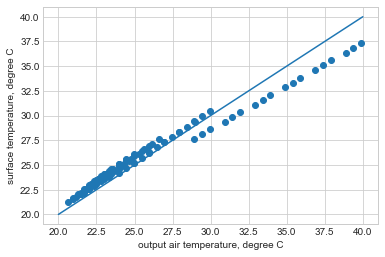

In [34]:
xs = []
ys = []

for v in [300.0, 600.0, 900.0, 1200.0, 1500.0, 1800.0]:
    for theta_in in [19.0, 19.5, 20.0]:
        for q_hs in [1000.0, 1200.0, 1400.0, 1600.0, 1800.0, 2000.0]:
            theta_hs_out_h = get_theta_hs_out_h(theta_in, q_hs, v)
            theta_surf_hex = get_theta_surf_hex_h(theta_in, theta_hs_out_h, q_hs, v)
            xs.append(theta_hs_out_h)
            ys.append(theta_surf_hex)

plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()
ax.scatter(xs, ys)

ax.set_xlabel('output air temperature, degree C')
ax.set_ylabel('surface temperature, degree C')

ax.plot([20.0, 40.0], [20.0, 40.0])

plt.show()

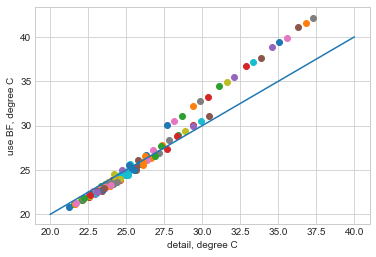

In [35]:
vs = [300.0, 600.0, 900.0, 1200.0, 1500.0, 1800.0]
theta_ins = [19.0, 19.5, 20.0]
q_hss = [1000.0, 1200.0, 1400.0, 1600.0, 1800.0, 2000.0]

plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

for v in vs:
    for theta_in in theta_ins:
        for q_hs in q_hss:
            theta_hs_out_h = get_theta_hs_out_h(theta_in, q_hs, v)
            theta_surf_hex = get_theta_surf_hex_h(theta_in, theta_hs_out_h, q_hs, v)
            ax.scatter(theta_surf_hex, calc_theta_surf_BF(v, theta_in, theta_hs_out_h, 0.1))            

ax.set_xlabel('detail, degree C')
ax.set_ylabel('use BF, degree C')

ax.plot([20.0, 40.0], [20.0, 40.0])

plt.show()

$$ \theta_{hs,out,C} = \theta_{hs,in,C} - \frac{ q_{hs,CS} }{ c \rho V_{hs,C} } \times 3600 $$

$\theta_{hs,out,C}$：冷房運転時の吐き出し温度, ℃  
$\theta_{hs,in,C}$：冷房運転時の吸い込み温度, ℃  
$q_{hs,CS}$：冷房顕熱能力, W  
$V_{hs,C}$：冷房運転時の風量, m<sup>3</sup>/h  
$\rho$：空気の密度, kg/m<sup>3</sup> (=1.2)    
$c$：空気の比熱, J/kgK (=1006.0)

In [36]:
def get_theta_hs_out_c(theta_hs_in_c, q_hs_cs, v_hs_c):
    
    # 空気の密度・空気の比熱の取得
    rho, c, l_wtr, calender = exp_general_property.get_general_property()

    return theta_hs_in_c - q_hs_cs / (c * rho * v_hs_c) * 3600

$ \theta_{hs,out,C,d,t} \lt \theta_{dp,C,d,t} $ の場合：

$$ \alpha_{c,hex,C} = \alpha'_{hex,C} \left( C_{pa,in,C} + C_{pw} \frac{ X_{e,in,C} + X_{e,te,C,d,t} }{ 2 } \right) \times 1000 $$

$ \theta_{hs,out,C,d,t} \ge \theta_{dp,C,d,t} $ の場合：

$$ \alpha_{c,hex,C} = \left( - 0.001679 \left( \frac{ V_{hs} \div 3600 }{ A_{f,hex} } \right)^2 + 0.044019 \left( \frac{ V_{hs} \div 3600 }{ A_{f,hex} } \right) + 0.02706 \right) \times 1000 $$

$$ \alpha'_{hex,C} = 0.050 \ln \left( \frac{ V_{hs} \div 3600 }{ A_{f,hex} } \right) + 0.073 $$

$$ C_{pw} = 1.846 $$

$\theta_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気温度, ℃  
$\theta_{dp,C,d,t}$：冷房時の熱源機の入口空気の露点温度, ℃  
$\alpha_{c,hex,C}$：冷房時における室内機熱交換器表面の顕熱伝達率, W/m<sup>2</sup> K  
$\alpha'_{hex}$：冷房時における室内機熱交換器表面の潜熱伝達率, kg/m<sup>2</sup>s  
$C_{pa,in,C}$：冷房時の乾き空気の定圧比熱, kJ/kg K  
$C_{pw}$：水蒸気定圧比熱, kJ/kg K  
$X_{e,in,C}$：冷房時の熱源機の入口空気の絶対湿度, kg/kg(DA)  
$X_{e,te,C,d,t}$：冷房時の熱源機の出口空気の絶対湿度, kg/kg(DA)  
$V_{hs}$：熱源機の風量, m<sup>3</sup>/h  
$A_{f,hex}$：室内機熱交換器の前面面積のうち熱交換に有効な面積, m<sup>2</sup>

### 顕熱伝達率を直接計算する方法と潜熱伝達率を求めてからルイスの関係を用いて顕熱伝達率を推定する方法の比較

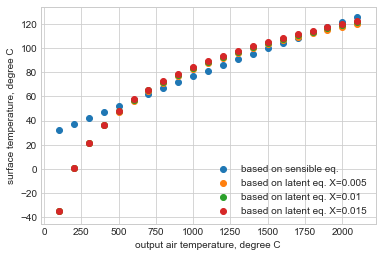

In [37]:
def get_alpha_from_sensible(v_hs):

    a_f_hex = get_a_f_hex()
    
    v = v_hs / 3600 / a_f_hex
    
    return (- 0.001679 * v ** 2 + 0.044019 * v + 0.02706) * 1000

def get_alpha_from_latent(v_hs, x_hs):

    a_f_hex = get_a_f_hex()

    v = v_hs / 3600 / a_f_hex

    alpha_d = 0.050 * np.log(v) + 0.073

    # specific heat of the vapour at constant pressure, kJ/kg K
    c_pw = 1.846

    # specific heat of the dry air  at constant pressure, kJ/kg K
    c_p_air = 1.006
    
    return alpha_d * ( c_p_air + c_pw * x_hs) * 1000
    
    
xs = []
ys = []


plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

v_hs = np.arange(start= 100.0, stop= 2200.0, step = 100.0)
ax.scatter(v_hs, np.vectorize(get_alpha_from_sensible)(v_hs), label='based on sensible eq.')
ax.scatter(v_hs, np.vectorize(get_alpha_from_latent)(v_hs, 0.005), label='based on latent eq. X=0.005')
ax.scatter(v_hs, np.vectorize(get_alpha_from_latent)(v_hs, 0.01), label='based on latent eq. X=0.01')
ax.scatter(v_hs, np.vectorize(get_alpha_from_latent)(v_hs, 0.015), label='based on latent eq. X=0.015')

ax.set_xlabel('output air temperature, degree C')
ax.set_ylabel('surface temperature, degree C')

plt.legend()

plt.show()

風量400m3/h以下において潜熱伝達率から計算する方法の精度が低くなることが予想されるため、400m3/h以下においては400m3/hにおける推定結果を使うように修正する。

$$ \theta_{surf,C,hex} = \frac{\theta_{hs,in,C} + \theta_{hs,out,C}}{2} - \frac{q_{hs,CS} }{A_{e,hex} \alpha_{c,hex,C}} $$

$\theta_{surf,C,hex}$：冷房時の室内機熱交換器の表面温度, ℃  
$q_{hs,CS}$：冷房顕熱能力, W  
$\theta_{hs,out,C,d,t}$：冷房時の熱源機の出口空気温度, ℃  
$\theta_{hs,in,H,d,t}$：冷房時の熱源機の入口空気温度, ℃  
$\alpha_{c,hex,C}$：冷房時の室内機熱交換器表面の顕熱伝達率, W/m<sup>2</sup> K  
$A_{e,hex}$：室内機熱交換器の表面積のうち熱交換に有効な面積, m<sup>2</sup>

In [38]:
def get_theta_surf_hex_c(
        theta_hs_in_c: float, theta_hs_out_c: float, x_hs_in_c: float, x_hs_out_c: float, q_hs_cs: float, v_hs: float) -> float:
    """
    Args:
        theta_hs_in_c: inlet air temperature of the heat source for cooling, degree C
        theta_hs_out_c: outlet air temperature of the heat source for cooling, degree C
        x_hs_in_c: inlet air absolute humidity of the heat source for cooling, kg/kgDA
        x_hs_out_c: outlet air absolute humidity of the heat source for cooling, kg/kgDA
        q_hs_cs: sensible cooling capacity of the heat source, W
        v_hs: air volume of heat source, m3/h
    Returns:
        surface temperature of heat exchanger, degree C
    """
    
    a_f_hex = get_a_f_hex()

    a_e_hex = get_a_e_hex()

    # saturated vapour pressure of the outlet air, Pa
    p_vs_hs_out_c = cs.get_saturated_vapour_pressure_by_temperature(theta_hs_out_c)

    # vapour pressure of the inlet air, Pa
    p_v_hs_in_c = cs.get_vapour_pressure_by_absolute_humidity(x_hs_in_c)

    # specific heat of the vapour at constant pressure, kJ/kg K
    c_pw = 1.846

    # specific heat of the dry air  at constant pressure, kJ/kg K
    c_p_air = 1.006

    v = v_hs / 3600 / a_f_hex

    if p_vs_hs_out_c < p_v_hs_in_c:
        alpha_d_hex_c = 0.050 * np.log(v) + 0.073
        alpha_c_hex_c = alpha_d_hex_c * ( c_p_air + c_pw * (x_hs_in_c + x_hs_out_c) / 2 ) * 1000
    else:
        alpha_d_hex_c = 0.0
        alpha_c_hex_c = (- 0.001679 * v ** 2 + 0.0044019 * v + 0.02706) * 1000

    return (theta_hs_in_c + theta_hs_out_c) / 2 - q_hs_cs / (a_e_hex * alpha_c_hex_c)

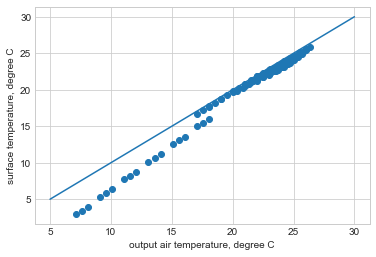

In [39]:
xs = []
ys = []

for v in [300.0, 600.0, 900.0, 1200.0, 1500.0, 1800.0]:
    for theta_in in [27.0, 27.5, 28.0]:
        for q_hs in [1000.0, 1200.0, 1400.0, 1600.0, 1800.0, 2000.0]:
            theta_hs_out_c = get_theta_hs_out_c(theta_in, q_hs, v)
            theta_surf_hex = get_theta_surf_hex_c(theta_in, theta_hs_out_c, 0.026, 0.024, q_hs, v)
            xs.append(theta_hs_out_c)
            ys.append(theta_surf_hex)

plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()
ax.scatter(xs, ys)

ax.set_xlabel('output air temperature, degree C')
ax.set_ylabel('surface temperature, degree C')

ax.plot([5.0, 30.0], [5.0, 30.0])

plt.show()

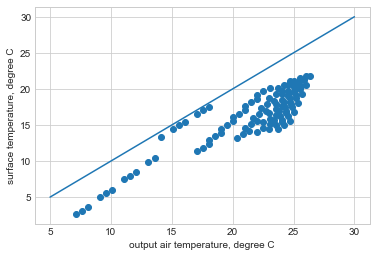

In [40]:
xs = []
ys = []

for v in [300.0, 600.0, 900.0, 1200.0, 1500.0, 1800.0]:
    for theta_in in [27.0, 27.5, 28.0]:
        for q_hs in [1000.0, 1200.0, 1400.0, 1600.0, 1800.0, 2000.0]:
            theta_hs_out_c = get_theta_hs_out_c(theta_in, q_hs, v)
            theta_surf_hex = get_theta_surf_hex_c(theta_in, theta_hs_out_c, 0.010, 0.015, q_hs, v)
            xs.append(theta_hs_out_c)
            ys.append(theta_surf_hex)

plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()
ax.scatter(xs, ys)

ax.set_xlabel('output air temperature, degree C')
ax.set_ylabel('surface temperature, degree C')

ax.plot([5.0, 30.0], [5.0, 30.0])

plt.show()

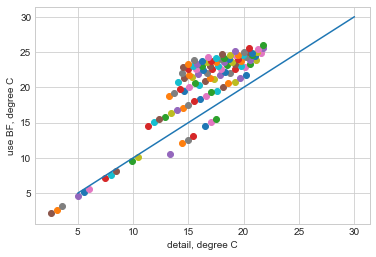

In [41]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

for v in [300.0, 600.0, 900.0, 1200.0, 1500.0, 1800.0]:
    for theta_in in [27.0, 27.5, 28.0]:
        for q_hs in [1000.0, 1200.0, 1400.0, 1600.0, 1800.0, 2000.0]:
            theta_hs_out_c = get_theta_hs_out_c(theta_in, q_hs, v)
            theta_surf_hex = get_theta_surf_hex_c(theta_in, theta_hs_out_c, 0.010, 0.015, q_hs, v)
            ax.scatter(theta_surf_hex, calc_theta_surf_BF(v, theta_in, theta_hs_out_c, 0.2))

ax.set_xlabel('detail, degree C')
ax.set_ylabel('use BF, degree C')

ax.plot([5.0, 30.0], [5.0, 30.0])

plt.show()

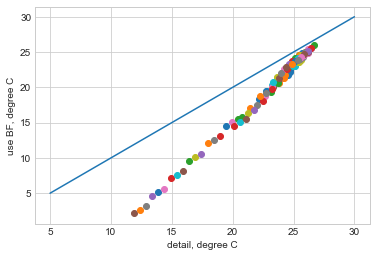

In [42]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = fig.subplots()

for v in [300.0, 600.0, 900.0, 1200.0, 1500.0, 1800.0]:
    for theta_in in [27.0, 27.5, 28.0]:
        for q_hs in [1000.0, 1200.0, 1400.0, 1600.0, 1800.0, 2000.0]:
            theta_hs_out_c = get_theta_hs_out_c(theta_in, q_hs, v)
            theta_surf_hex = get_theta_surf_hex_c(theta_in, theta_hs_out_c, 1.010, 1.015, q_hs, v)
            ax.scatter(theta_surf_hex, calc_theta_surf_BF(v, theta_in, theta_hs_out_c, 0.2))

ax.set_xlabel('detail, degree C')
ax.set_ylabel('use BF, degree C')

ax.plot([5.0, 30.0], [5.0, 30.0])

plt.show()